# Deep learning for Natural Language Processing


 * Simple text representations, bag of words
 * Word embedding and... not just another word2vec this time
 * rnn for text
 * Aggregating several data sources "the hard way"
 * Solving ~somewhat~ real ML problem with ~almost~ end-to-end deep learning
 

Special thanks to Irina Golzmann for help with technical part, task prepared by Александр Панин, jheuristic@yandex-team.ru

# NLTK

You will require nltk v3.2 to solve this assignment

__It is really important that the version is 3.2, otherwize russian tokenizer might not work__

Install/update
* `sudo pip install --upgrade nltk==3.2`
* If you don't remember when was the last pip upgrade, `sudo pip install --upgrade pip`

If for some reason you can't or won't switch to nltk v3.2, just make sure that russian words are tokenized properly with RegeExpTokenizer.

# For students with low-RAM machines
 * This assignment can be accomplished with even the low-tier hardware (<= 4Gb RAM) 
 * If that is the case, turn flag "low_RAM_mode" below to True
 * If you have around 8GB memory, it is unlikely that you will feel constrained by memory.
 * In case you are using a PC from last millenia, consider setting very_low_RAM=True

In [3]:
from IPython.display import display, HTML, SVG, Image, display_html
pd.set_option('display.max_colwidth', 500)
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML('''<style>
.widget-label { min-width: 20ex !important; }
</style>'''))

In [38]:
low_RAM_mode = True
very_low_RAM = False  #If you have <3GB RAM, set BOTH to true

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn
%matplotlib inline

# Dataset

Ex-kaggle-competition on prohibited content detection

There goes the description - https://www.kaggle.com/c/avito-prohibited-content


### Download
High-RAM mode,
 * Download avito_train.tsv from competition data files
Low-RAM-mode,
 * Download downsampled dataset from here
     * archive https://yadi.sk/d/l0p4lameqw3W8
     * raw https://yadi.sk/d/I1v7mZ6Sqw2WK (in case you feel masochistic)
 




# What's inside
Different kinds of features:
* 2 text fields - title and description
* Special features - price, number of e-mails, phones, etc
* Category and subcategory - unsurprisingly, categorical features
* Attributes - more factors

Only 1 binary target whether or not such advertisement contains prohibited materials
* criminal, misleading, human reproduction-related, etc
* diving into the data may result in prolonged sleep disorders

In [39]:
if not low_RAM_mode:
    # a lot of ram
    df = pd.read_csv("avito_train.tsv",sep='\t')
else:
    #aroung 4GB ram
    df = pd.read_csv("avito_train_1kk.tsv",sep='\t') 

In [40]:
print(df.shape, df.is_blocked.mean())
df[:2]

((1204949, 13), 0.22822210732570425)


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03
1,10000094,Личные вещи,"Одежда, обувь, аксессуары",Костюм Steilmann,Юбка и топ из панбархата. Под топ трикотажная...,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",1500,NaN,0,0,0,0,0.41


In [41]:
print("Blocked ratio",df.is_blocked.mean())
print("Count:",len(df))

('Blocked ratio', 0.22822210732570425)
('Count:', 1204949)


# Balance-out the classes
* Vast majority of data samples are non-prohibited
 * 250k banned out of 4kk
 * Let's just downsample random 250k legal samples to make further steps less computationally demanding
 * If you aim for high Kaggle score, consider a smarter approach to that.


In [42]:
#downsample
#downsample data so that both classes have approximately equal ratios
sampled_df = [row for row in df.itertuples() if row.is_blocked == 1]
positive_examples = [row for row in df.itertuples() if row.is_blocked == 0]
random.shuffle(positive_examples)
add_to_samples = len(sampled_df)
for i in range(add_to_samples):
    sampled_df.append(positive_examples[i])

In [43]:
cols = list(df.columns.values)
new_cols = ['id']
for item in cols:
    new_cols.append(item)
df = pd.DataFrame(sampled_df, columns = new_cols)
del df['id']
print("Blocked ratio:",df.is_blocked.mean())
print("Count:",len(df))
df[:2]

('Blocked ratio:', 0.5)
('Count:', 549992)


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000317,Услуги,Предложения услуг,"Поездки на таможню, печать в паспорте",Поездки на таможню гражданам СНГ для пересечен...,"{""Вид услуги"":""Деловые услуги"", ""Тип услуги"":""...",1500,0.0,1,0,0,0,1.43
1,10000478,Услуги,Предложения услуг,Рефлекторно-урогинекологический массаж,Комбинированная методика рефлекторных техник м...,"{""Вид услуги"":""Красота, здоровье""}",1000,0.0,1,0,0,0,1.19


In [44]:
assert df.is_blocked.mean() < 0.51
assert df.is_blocked.mean() > 0.49
assert len(df) <= 560000

print "All tests passed"

All tests passed


# Tokenizing

First, we create a dictionary of all existing words.
Assign each word a number - it's Id

In [45]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")

#Dictionary of tokens
token_counts = Counter()

#All texts
all_texts = np.hstack([df.description.values,df.title.values])

#Compute token frequencies
for s in all_texts:
    if type(s) is not str:
        continue
    s = s.decode('utf8').lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1

### Remove rare tokens

We are unlikely to make use of words that are only seen a few times throughout the corpora.

Again, if you want to beat Kaggle competition metrics, consider doing something better.

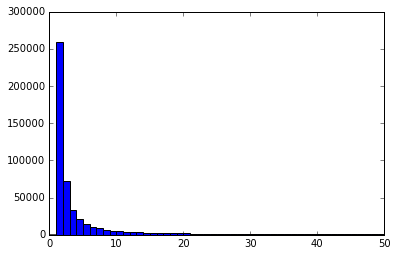

In [46]:
#Word frequency distribution, just for kicks
_=plt.hist(token_counts.values(),range=[0,50],bins=50)

In [47]:
#Select only the tokens that had at least 10 occurences in the corpora.
#Use token_counts.
min_count = 10
tokens = []
for token in token_counts:
    if token_counts[token] >= 10:
        tokens.append(token)

In [48]:
token_to_id = {t:i+1 for i,t in enumerate(tokens)}
null_token = "NULL"
token_to_id[null_token] = 0

In [49]:
print "# Tokens:",len(token_to_id)
if len(token_to_id) < 30000:
    print "Alarm! It seems like there are too few tokens. Make sure you updated NLTK and applied correct thresholds -- unless you now what you're doing, ofc"
if len(token_to_id) > 1000000:
    print "Alarm! Too many tokens. You might have messed up when pruning rare ones -- unless you know what you're doin' ofc"

# Tokens: 87940


### Replace words with IDs
Set a maximum length for titles and descriptions.
 * If string is longer that that limit - crop it, if less - pad with zeros.
 * Thus we obtain a matrix of size [n_samples]x[max_length]
 * Element at i,j - is an identifier of word j within sample i

In [51]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        s = s.decode('utf8').lower()
        tokens = tokenizer.tokenize(s)
        token_ids = map(lambda token: token_to_id.get(token,0), tokens)[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [52]:
desc_tokens = vectorize(df.description.values,token_to_id,max_len = 150)
title_tokens = vectorize(df.title.values,token_to_id,max_len = 15)

### Data format examples


In [53]:
print "Размер матрицы:",title_tokens.shape
for title, tokens in zip(df.title.values[:3],title_tokens[:3]):
    print title,'->', tokens[:10],'...'

Размер матрицы: (549992, 15)
Поездки на таможню, печать в паспорте -> [43320 14749 55452 82157 80237 17397     0     0     0     0] ...
Рефлекторно-урогинекологический массаж -> [ 8412     0 30493     0     0     0     0     0     0     0] ...
Возьму суду под200 т. р -> [28859 23476     0  3674 33977     0     0     0     0     0] ...


__ As you can see, our preprocessing is somewhat crude. Let us see if that is enough for our network __

# Non-sequences


Some data features are not text samples. E.g. price, # urls, category, etc

They require a separate preprocessing.

In [54]:
#All numeric features
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]

In [55]:
#One-hot-encoded category and subcategory

from sklearn.feature_extraction import DictVectorizer

categories = []
data_cat_subcat = df[["category","subcategory"]].values

categories = [{"category": row.category, "subcategory": row.subcategory} for row in df.itertuples()]

vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)

In [56]:
df_non_text = pd.merge(
    df_numerical_features,cat_one_hot,on = np.arange(len(cat_one_hot))
)
del df_non_text["key_0"]
df_non_text[:5]

,phones_cnt,emails_cnt,urls_cnt,price,category=Бытовая электроника,category=Для бизнеса,category=Для дома и дачи,category=Животные,category=Личные вещи,category=Недвижимость,...,subcategory=Резюме,subcategory=Ремонт и строительство,subcategory=Собаки,subcategory=Спорт и отдых,subcategory=Телефоны,subcategory=Товары для детей и игрушки,subcategory=Товары для животных,subcategory=Товары для компьютера,subcategory=Фототехника,subcategory=Часы и украшения
0,0,0,0,1500,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,18,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
def get_non_text_features(df):
    categories = []
    data_cat_subcat = df[["category","subcategory"]].values
    categories = [{"category": row.category, "subcategory": row.subcategory} for row in df.itertuples()]
    df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]
    vectorizer = DictVectorizer(sparse=False)
    cat_one_hot = vectorizer.fit_transform(categories)
    cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)
    df_non_text = pd.merge(
        df_numerical_features,cat_one_hot,on = np.arange(len(cat_one_hot))
    )
    del df_non_text["key_0"]
    return df_non_text

# Split data into training and test

In [59]:
#Target variable - whether or not sample contains prohibited material
target = df.is_blocked.values.astype('int32')
#Preprocessed titles
title_tokens = title_tokens.astype('int32')
#Preprocessed tokens
desc_tokens = desc_tokens.astype('int32')
#Non-sequences
df_non_text = df_non_text.astype('float32')

In [60]:
#Split into training and test set.
from sklearn.cross_validation import train_test_split
title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = train_test_split(
title_tokens, desc_tokens, df_non_text, target)
data_tuple = (title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts)

## Save preprocessed data [optional]

* The next tab can be used to stash all the essential data matrices and get rid of the rest of the data.
 * Highly recommended if you have less than 1.5GB RAM left
* To do that, you need to first run it with save_prepared_data=True, then restart the notebook and only run this tab with read_prepared_data=True.

In [1]:
save_prepared_data = False #save
read_prepared_data = True #load

#but not both at once
assert not (save_prepared_data and read_prepared_data)

if save_prepared_data:
    print "Saving preprocessed data (may take up to 3 minutes)"

    import pickle
    with open("preprocessed_data.pcl",'w') as fout:
        pickle.dump(data_tuple,fout)
    with open("token_to_id.pcl",'w') as fout:
        pickle.dump(token_to_id,fout)

    print "готово"
    
elif read_prepared_data:
    print "Reading saved data..."
    
    import pickle
    
    with open("preprocessed_data.pcl",'r') as fin:
        data_tuple = pickle.load(fin)
    title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple
    with open("token_to_id.pcl",'r') as fin:
        token_to_id = pickle.load(fin)
        
    #Re-importing libraries to allow staring noteboook from here
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
   
    print "done"        

Reading saved data...
done


In [2]:
print len(desc_tr), len(title_tr), len(nontext_tr), len(target_tr)
print len(desc_ts), len(title_ts), len(nontext_ts), len(target_ts)

412494 412494 412494 412494
137498 137498 137498 137498


# Train the monster

Since we have several data sources, our neural network may differ from what you used to work with.

* Separate input for titles: RNN
* Separate input for description: RNN
* Separate input for categorical features: обычные полносвязные слои или какие-нибудь трюки
 
These three inputs must be blended somehow - concatenated or added.

* Output: a simple binary classification
 * 1 sigmoidal with binary_crossentropy
 * 2 softmax with categorical_crossentropy - essentially the same as previous one
 * 1 neuron without nonlinearity (lambda x: x) +  hinge loss
 

In [3]:
#libraries
import lasagne
from theano import tensor as T
import theano

/home/alexandero/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [4]:
#3 inputs and a refere output
title_token_ids = T.matrix("title_token_ids",dtype='int32')
desc_token_ids = T.matrix("desc_token_ids",dtype='int32')
categories = T.matrix("categories",dtype='float32')
target_y = T.ivector("is_blocked")

# NN architecture

In [5]:
print(title_tr.shape)
title_inp = lasagne.layers.InputLayer((None,title_tr.shape[1]),input_var=title_token_ids)
descr_inp = lasagne.layers.InputLayer((None,desc_tr.shape[1]),input_var=desc_token_ids)
cat_inp = lasagne.layers.InputLayer((None,nontext_tr.shape[1]), input_var=categories)

(412494, 15)


In [6]:
# Descriptions
hidden_layers = 60
#word-wise embedding. We recommend to start from some 64 and improving after you are certain it works.
descr_nn_pre = lasagne.layers.EmbeddingLayer(descr_inp, input_size=len(token_to_id)+1, output_size=64)
descr_nn = lasagne.layers.LSTMLayer(descr_nn_pre, hidden_layers, grad_clipping=100, nonlinearity=lasagne.nonlinearities.tanh)
desc_a, desc_b = lasagne.layers.get_output_shape(descr_nn)[1:]
descr_nn = lasagne.layers.ReshapeLayer(descr_nn, (-1, desc_a * desc_b))

# Titles
title_nn_pre = lasagne.layers.EmbeddingLayer(title_inp, input_size=len(token_to_id)+1, output_size=64)
title_nn = lasagne.layers.LSTMLayer(title_nn_pre, hidden_layers, grad_clipping=100, nonlinearity=lasagne.nonlinearities.tanh)
title_a, title_b = lasagne.layers.get_output_shape(title_nn)[1:]
title_nn = lasagne.layers.ReshapeLayer(title_nn, (-1, title_a * title_b))

# Non-sequence
cat_nn = lasagne.layers.DenseLayer(cat_inp, hidden_layers, W = lasagne.init.Normal(), nonlinearity=lasagne.nonlinearities.tanh)

In [7]:
print(lasagne.layers.get_output_shape(title_nn))
print(lasagne.layers.get_output_shape(descr_nn))
print(lasagne.layers.get_output_shape(cat_nn))

(None, 900)
(None, 9000)
(None, 60)


In [8]:
nn = lasagne.layers.concat([descr_nn, title_nn, cat_nn]) #<merge three layers into one (e.g. lasagne.layers.concat) >                                  

nn = lasagne.layers.DenseLayer(nn,20,nonlinearity=lasagne.nonlinearities.sigmoid)
nn = lasagne.layers.DropoutLayer(nn,p=0.1)
nn = lasagne.layers.DenseLayer(nn,1,nonlinearity=lasagne.nonlinearities.linear)

# Loss function

* The standard way:
 * prediction
 * loss
 * updates
 * training and evaluation functions
 
 
* Hinge loss
 * $ L_i = \max(0, \delta - t_i p_i) $
 * delta is a tunable parameter: how far should a neuron be in the positive margin area for us to stop bothering about it
 * Function description may mention some +-1  limitations - this is not neccessary, at least as long as hinge loss has a __default__ flag `binary = True`

In [28]:
#All trainable params
weights = lasagne.layers.get_all_params(nn,trainable=True)

In [29]:
#Simple NN prediction
prediction = lasagne.layers.get_output(nn)[:,0]

#Hinge loss
loss = lasagne.objectives.binary_hinge_loss(prediction,target_y).mean()

In [30]:
#Weight optimization step
updates = lasagne.updates.nesterov_momentum(loss, weights, learning_rate=0.01, momentum=0.9)

### Determinitic prediction 
 * In case we use stochastic elements, e.g. dropout or noize
 * Compile a separate set of functions with deterministic prediction (deterministic = True)
 * Unless you think there's no neet for dropout there ofc. Btw is there?

In [31]:
#deterministic version
det_prediction = lasagne.layers.get_output(nn,deterministic=True)[:,0]

#equivalent loss function
det_loss = lasagne.objectives.binary_hinge_loss(det_prediction,target_y).mean()

### Coffee-lation

In [32]:
train_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[loss,prediction],updates = updates,
                           on_unused_input='warn')
eval_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[det_loss,det_prediction],
                           on_unused_input='warn')

# Training loop
* The regular way with loops over minibatches
* Since the dataset is huge, we define epoch as some fixed amount of samples isntead of all dataset

In [14]:
#average precision at K

from oracle import APatK, score

In [15]:
# Out good old minibatch iterator now supports arbitrary amount of arrays (X,y,z)

def iterate_minibatches(*arrays,**kwargs):
    batchsize=kwargs.get("batchsize",10)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]

### Tweaking guide

* batch_size - how many samples are processed per function call
  * optimization gets slower, but more stable, as you increase it.
  * May consider increasing it halfway through training
* minibatches_per_epoch - max amount of minibatches per epoch
  * Does not affect training. Lesser value means more frequent and less stable printing
  * Setting it to less than 10 is only meaningfull if you want to make sure your NN does not break down after one epoch
* n_epochs - total amount of epochs to train for
  * `n_epochs = 10**10` and manual interrupting is still an option


Tips:

* With small minibatches_per_epoch, network quality may jump around 0.5 for several epochs

* AUC is the most stable of all three metrics

* Average Precision at top 2.5% (APatK) - is the least stable. If batch_size*minibatches_per_epoch < 10k, it behaves as a uniform random variable.

* Plotting metrics over training time may be a good way to analyze which architectures work better.

* Once you are sure your network aint gonna crash, it's worth letting it train for a few hours of an average laptop's time to see it's true potential

In [23]:
from sklearn.metrics import roc_auc_score, accuracy_score

n_epochs = 50
batch_size = 50
minibatches_per_epoch = 50

for i in range(n_epochs):
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_tr,title_tr,nontext_tr.values,target_tr,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch:
            break
        #print b_desc.shape, b_title.shape, b_cat.shape, b_y.shape
        loss,pred_probas = train_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c += 1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)
    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
#if i % 20 == 0:
    print "Train:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_ts,title_ts,nontext_ts.values,target_ts,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch: 
            break
        loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
        
#if i % 20 == 0:
    print "Val:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

Train:
	loss: 0.23318696699
	acc: 0.894901960784
	auc: 0.942508305648
	ap@k: 0.997930913298
Val:
	loss: 0.22927643824
	acc: 0.896078431373
	auc: 0.955732200834
	ap@k: 1.0
Train:
	loss: 0.210971251452
	acc: 0.907058823529
	auc: 0.946495007456
	ap@k: 0.988802410808
Val:
	loss: 0.216659721091
	acc: 0.901176470588
	auc: 0.95525894412
	ap@k: 1.0
Train:
	loss: 0.220917736277
	acc: 0.903137254902
	auc: 0.941876366016
	ap@k: 1.0
Val:
	loss: 0.221239285026
	acc: 0.895294117647
	auc: 0.955742756156
	ap@k: 1.0
Train:
	loss: 0.209427582025
	acc: 0.904705882353
	auc: 0.947202836782
	ap@k: 1.0
Val:
	loss: 0.227909049297
	acc: 0.896862745098
	auc: 0.951967914596
	ap@k: 0.993482060983
Train:
	loss: 0.217950074523
	acc: 0.902352941176
	auc: 0.938688684532
	ap@k: 1.0
Val:
	loss: 0.21919516485
	acc: 0.896078431373
	auc: 0.951777618061
	ap@k: 1.0
Train:
	loss: 0.213164054301
	acc: 0.90431372549
	auc: 0.946068528543
	ap@k: 1.0
Val:
	loss: 0.217716901464
	acc: 0.901568627451
	auc: 0.956353073187
	ap@k: 1.0


Val:
	loss: 0.211046944459
	acc: 0.903529411765
	auc: 0.955027032746
	ap@k: 1.0
Train:
	loss: 0.168401252657
	acc: 0.924705882353
	auc: 0.963325078066
	ap@k: 1.0
Val:
	loss: 0.214543252383
	acc: 0.897647058824
	auc: 0.956058558212
	ap@k: 1.0


In [ ]:
print "If you are seeing this, it's time to backup your notebook. No, really, 'tis too easy to mess up everything without noticing. "

# Final evaluation
Evaluate network over the entire test set

In [24]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

b_c = b_loss = 0
for j, (b_desc,b_title,b_cat, b_y) in enumerate(
    iterate_minibatches(desc_ts,title_ts,nontext_tr.values,target_ts,batchsize=batch_size,shuffle=True)):
    loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

final_accuracy = accuracy_score(epoch_y_true,epoch_y_pred>0)
final_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
final_apatk = APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

print "Scores:"
print '\tloss:',b_loss/b_c
print '\tacc:',final_accuracy
print '\tauc:',final_auc
print '\tap@k:',final_apatk
score(final_accuracy,final_auc,final_apatk)

Scores:
	loss: 0.213776332477
	acc: 0.900225536559
	auc: 0.951652897929
	ap@k: 0.9962958859

AUC:
	Сойдёт, хотя можно ещё поднажать (ok)

Accuracy:
	Всё ок (ok)

Average precision at K:
	Засабмить на kaggle! (great) 
	 Нет, ну честно - выкачай avito_test.tsv, засабмить и скажи, что вышло.


# Main task

* https://goo.gl/forms/eJwIeAbjxzVuo6vn1
* Feel like Le'Cun:
 * accuracy > 0.95
 * AUC > 0.97
 * Average Precision at (test sample size * 0.025) > 0.99
 * And perhaps even farther

* Casual mode
 * accuracy > 0.90
 * AUC > 0.95
 * Average Precision at (test sample size * 0.025) > 0.92

* Remember the training, Luke
 * Dropout, regularization
 * Mommentum, RMSprop, ada*
 * etc etc etc
 
 * If you have background in texts, there may be a way to improve tokenizer, add some lemmatization, etc etc.
 * In case you know how not to shoot yourself in the foot with RNNs, they too may be of some use.